# The pytesmo validation framework

The pytesmo validation framework takes care of iterating over datasets, spatial and temporal matching as well as
scaling. It uses metric calculators to then calculate metrics that are returned to the user. There are several
metrics calculators included in pytesmo but new ones can be added simply.

## Overview

How does the validation framework work? It makes these assumptions about the used datasets:

- The dataset readers that are used have a method for reading data (usually called `read`) that can be called either by a grid point index (gpi) which can be any indicator that identifies a certain grid point or by using longitude and latitude. This means that both call signatures `read(gpi)` and `read(lon, lat)` must be valid. Please check the [pygeobase](https://github.com/TUW-GEO/pygeobase) documentation for more details on how a fully compatible dataset class should look. But a simple `read` method should do for the validation framework. This assumption can be relaxed by using the `read_ts_names` keyword in the pytesmo.validation_framework.data_manager.DataManager class.
- **The reading method returns a pandas.DataFrame time series.**
- Ideally the datasets classes also have a `grid` attribute that is a
  [pygeogrids](http://pygeogrids.readthedocs.org/en/latest/) grid. This makes the calculation of lookup tables easily possible and the nearest neighbor search faster.

Fortunately these assumptions are true about the dataset readers included in pytesmo. 

It also makes a few assumptions about how to perform a validation. For a comparison study it is often necessary to
choose a spatial reference grid, a temporal reference and a scaling or data space reference.

### Spatial reference
The spatial reference is the one to which all the other datasets are matched spatially. Often through nearest
neighbor search. The validation framework uses grid points of the dataset specified as the spatial reference to
spatially match all the other datasets with nearest neighbor search. Other, more sophisticated spatial matching
algorithms are not implemented at the moment. If you need a more complex spatial matching then a preprocessing of
the data is the only option at the moment.

### Temporal reference
The temporal reference is the dataset to which the other dataset are temporally matched. That means that the
nearest observation to the reference timestamps in a certain time window is chosen for each comparison dataset.
This is by default done by the temporal matching module included in pytesmo. How many datasets should be matched to
the reference dataset at once can be configured, we will cover how to do this later.

### Data space reference
It is often necessary to bring all the datasets into a common data space by using. Scaling is often used for that
and pytesmo offers a choice of several scaling algorithms (e.g. CDF matching, min-max scaling, mean-std scaling,
triple collocation based scaling). The data space reference can also be chosen independently from the other two
references.

## Data Flow

After it is initialized, the validation framework works through the following steps:

1. Read all the datasets for a certain job (gpi, lon, lat)
2. Read all the masking dataset if any
3. Mask the temporal reference dataset using the masking data
4. Temporally match all the chosen combinations of temporal reference and other datasets
5. Turn the temporally matched time series over to the metric calculators
6. Get the calculated metrics from the metric calculators
7. Put all the metrics into a dictionary by dataset combination and return them.

## Masking datasets
Masking datasets can be used if the datasets that are compared do not contain the necessary information to mask
 them. For example we might want to use modelled soil temperature data to mask our soil moisture observations
before comparing them. To be able to do that we just need a Dataset that returns a pandas.DataFrame with one column
 of boolean data type. Everywhere where the masking dataset is `True` the data will be masked.

Let's look at a first example.

## Example soil moisture validation: ASCAT - ISMN

This example shows how to setup the pytesmo validation framework to perform a comparison between ASCAT and ISMN data. 


In [1]:
import os
import numpy as np
from pathlib import Path
from pprint import pprint
import pytesmo.validation_framework.metric_calculators as metrics_calculators
from datetime import datetime
import warnings
from ascat.read_native.cdr import AscatGriddedNcTs

from ismn.interface import ISMN_Interface  # install ismn: 'pip install ismn'
from pytesmo.validation_framework.validation import Validation
from pytesmo.validation_framework.results_manager import netcdf_results_manager
from pytesmo.utils import rootdir

import tempfile

You need the test data from https://github.com/TUW-GEO/pytesmo-test-data for this example

In [2]:
from tempfile import mkdtemp
output_folder = Path(mkdtemp())
print('Data is stored in:', output_folder)

Data is stored in: /tmp/tmppeisd__e


First we initialize the data readers that we want to use. In this case the ASCAT soil moisture time series and in
situ data from the ISMN.

Initialize ASCAT reader

In [3]:
testdata_path = rootdir() / "tests" / "test-data"
ascat_data_folder = testdata_path / "sat" / "ascat" / "netcdf" / "55R22"
ascat_grid_fname = testdata_path / "sat" / "ascat" / "netcdf" / "grid" / "TUW_WARP5_grid_info_2_1.nc"
static_layer_path = testdata_path / "sat" / "h_saf" / "static_layer"


#init the AscatSsmCdr reader with the paths
with warnings.catch_warnings():
    warnings.filterwarnings('ignore') # some warnings are expected and ignored
    
    ascat_reader = AscatGriddedNcTs(
        ascat_data_folder,
        "TUW_METOP_ASCAT_WARP55R22_{:04d}",
        grid_filename=ascat_grid_fname,
        static_layer_path=static_layer_path
    )

ascat_reader.read_bulk = True

Initialize ISMN reader

In [4]:
ismn_data_folder = testdata_path / "ismn/multinetwork/header_values"
meta_path = tempfile.mkdtemp()
ismn_reader = ISMN_Interface(ismn_data_folder, meta_path=meta_path)

Processing metadata for all ismn stations into folder /home/wpreimes/shares/home/code/pytesmo/tests/test-data/ismn/multinetwork/header_values.
This may take a few minutes, but is only done once...
Hint: Use `parallel=True` to speed up metadata generation for large datasets


Files Processed: 100%|██████████| 8/8 [00:00<00:00, 65.44it/s]

Metadata generation finished after 0 Seconds.
Metadata and Log stored in /tmp/tmp_72gspsz
Found existing ismn metadata in /tmp/tmp_72gspsz/header_values.csv.


The validation is run based on jobs. A job consists of at least three lists or numpy arrays specifing the grid
point index, its latitude and longitude. In the case of the ISMN we can use the `dataset_ids` that identify every
time series in the downloaded ISMN data as our grid point index. We can then get longitude and latitude from the
metadata of the dataset.

**DO NOT CHANGE** the name ***jobs*** because it will be searched during the parallel processing!

In [5]:
jobs = []

ids = ismn_reader.get_dataset_ids(variable='soil_moisture', min_depth=0, max_depth=0.1)

for idx in ids:
    metadata = ismn_reader.read_metadata(idx)
    jobs.append((idx, metadata['longitude'].val, metadata['latitude'].val))
    break

print("Jobs (gpi, lon, lat):")
print(jobs)

Jobs (gpi, lon, lat):
[(0, 102.1333, 33.8833)]


For this example we only process one job / pixel / sensor.

It is important here that the ISMN reader has a reading function that works by just using the `dataset_id`. In this
 way the validation framework can go through the jobs and read the correct time series.

In [6]:
data = ismn_reader.read(ids[0])
print('ISMN data example:')
print(data.head())

ISMN data example:
                     soil_moisture soil_moisture_flag soil_moisture_orig_flag
date_time                                                                    
2008-07-01 00:00:00            0.5                C03                       M
2008-07-01 01:00:00            0.5                C03                       M
2008-07-01 02:00:00            0.5                C03                       M
2008-07-01 03:00:00            0.5                C03                       M
2008-07-01 04:00:00            0.5                C03                       M


## Initialize the Validation class

The Validation class is the heart of the validation framework. It contains the information about which datasets to
read using which arguments or keywords and if they are spatially compatible. It also contains the settings about
which metric calculators to use and how to perform the scaling into the reference data space. It is initialized in
the following way:


In [7]:
datasets = {
    'ISMN': {
        'class': ismn_reader,
        'columns': ['soil_moisture']
    },
    'ASCAT': {
        'class': ascat_reader,
        'columns': ['sm'],
        'kwargs': {'mask_frozen_prob': 80,
                   'mask_snow_prob': 80,
                   'mask_ssf': True}
    }}

The datasets dictionary contains all the information about the datasets to read. The `class` is the dataset class
to use which we have already initialized. The `columns` key describes which columns of the dataset interest us for
validation. This a mandatory field telling the framework which other columns to ignore. In this case the columns
`soil moisture_flag` and `soil moisture_orig_flag` will be ignored by the ISMN reader. We can also specify
additional keywords that should be given to the `read` method of the dataset reader. In this case we want the
ASCAT reader to mask the ASCAT soil moisture using the included frozen and snow probabilities as well as the SSF.
There are also other keys that can be used here. Please see the documentation for explanations.

In [10]:
period = [datetime(2007, 1, 1), datetime(2014, 12, 31)]
basic_metrics = metrics_calculators.PairwiseIntercomparisonMetrics()

process = Validation(
    datasets, 'ISMN',
    temporal_ref='ASCAT',
    scaling='mean_std',
    scaling_ref='ASCAT',
    metrics_calculators={(2, 2): basic_metrics.calc_metrics},
    period=period)

/home/wpreimes/shares/home/code/pytesmo/src/pytesmo/validation_framework/validation.py:144: UserWarning: You are using the default temporal matcher. If you are using one of the newer metric calculators (PairwiseIntercomparisonMetrics, TripleCollocationMetrics) you should probably use `make_combined_temporal_matcher` instead. Have a look at the documentation of the metric calculators for more info.
  warnings.warn(


During the initialization of the Validation class we can also tell it other things that it needs to know. In this
case it uses the datasets we have specified earlier. The spatial reference is the `'ISMN'` dataset which is the
second argument. The 'metrics_calculators' argument looks a little bit strange so let's look at it in more detail.

It is a dictionary with a tuple as the key and a function as the value. The key tuple `(n, k)` has the following
meaning: `n` datasets are temporally matched together and then given in sets of `k` columns to the metric
calculator. The metric calculator then gets a DataFrame with the columns ['ref', 'k1', 'k2' ...] and so on
depending on the value of k. The value of `(2, 2)` makes sense here since we only have two datasets and all our
metrics also take two inputs.

This can be used in more complex scenarios to e.g. have three input datasets that are all temporally matched
together and then combinations of two input datasets are given to one metric calculator while all three datasets
are given to another metric calculator. This could look like this:

```
{ (3 ,2): metric_calc,
  (3, 3): triple_collocation}
```

Create the variable ***save_path*** which is a string representing the path where the results will be saved.
**DO NOT CHANGE** the name ***save_path*** because it will be searched during the parallel processing!

In [11]:
save_path = output_folder / 'ascat_ismn'

for job in jobs:

    results = process.calc(*job)
    pprint(results)
    netcdf_results_manager(results, save_path)

{(('ASCAT', 'sm'), ('ISMN', 'soil_moisture')): {'BIAS': array([1.4210855e-14], dtype=float32),
                                                'BIAS_ci_lower': array([-1.124606], dtype=float32),
                                                'BIAS_ci_upper': array([1.124606], dtype=float32),
                                                'R': array([0.5342869], dtype=float32),
                                                'RMSD': array([10.789426], dtype=float32),
                                                'RSS': array([41558.98], dtype=float32),
                                                'R_ci_lower': array([0.45576647], dtype=float32),
                                                'R_ci_upper': array([0.60455596], dtype=float32),
                                                'gpi': array([0], dtype=int32),
                                                'lat': array([33.8833]),
                                                'lon': array([102.1333]),
               

The validation is then performed by looping over all the defined jobs and storing the results.
You can see that the results are a dictionary where the key is a tuple defining the exact combination of datasets
and columns that were used for the calculation of the metrics. The metrics itself are a dictionary of `metric-name:
 numpy.ndarray` which also include information about the gpi, lon and lat. Since all the information contained in
the job is given to the metric calculator they can be stored in the results.

Storing of the results to disk is at the moment supported by the `netcdf_results_manager` which creates a netCDF
file for each dataset combination and stores each metric as a variable. We can inspect the stored netCDF file which
 is named after the dictionary key:

In [12]:
import netCDF4
results_fname = Path(save_path) / "ASCAT.sm_with_ISMN.soil_moisture.nc"

with netCDF4.Dataset(str(results_fname)) as ds:
    for var in ds.variables:
        print(var, ds.variables[var][:])

lon [102.1333]
lat [33.8833]
idx [0]
_row_size [0]
time []
gpi [0]
status [0]
R [0.5342869]
p_R [9.664754e-28]
BIAS [1.4210855e-14]
RMSD [10.789426]
mse [116.41171]
RSS [41558.98]
mse_corr [116.41171]
mse_bias [2.019484e-28]
urmsd [10.789426]
mse_var [3.1554436e-30]
rho [0.53934574]
p_rho [2.471651e-28]
tau [0.3907124]
p_tau [2.1020434e-26]
BIAS_ci_lower [-1.124606]
BIAS_ci_upper [1.124606]
urmsd_ci_lower [10.065898]
urmsd_ci_upper [11.661137]
R_ci_lower [0.45576647]
R_ci_upper [0.60455596]
rho_ci_lower [0.45559874]
rho_ci_upper [0.61362934]
tau_ci_lower [0.35201582]
tau_ci_upper [0.42807564]
n_obs [357]


## Metric Calculator Adapters

Metric calculators compute a set of comparison metrics based on the passed input. Usually the input are two or more collocated time series. However, to validate soil moisture it is often desired to assess the quality for certain temporal subsets independently. E.g. if a varying level of agreement between two datasets is expected for two different seasons (e.g. wet/dry season, summer/winter) or if the varying level of agreement should be assessed (e.g. on a seasonal/monthly basis). In this case pytesmo provides adapters to split up the input time series before computing validation metrics. These adapters work with any (properly implemented) metric calculator. You can use one of the predefined adapters in `pytesmo.validation_framework.metric_calculators_adapters`. Currently, there are 2 options:

- `SubsetsMetricsAdapter`: This adapter lets you define arbitrary temporal subsets of your time series data before metrics computation. You can compute metrics for a certain set of datetimes or datetime ranges.
    - `MonthsMetricsAdapter`: This is a version of a SubsetsMetricsAdapter that allows splitting up the data based on their month. You can e.g. compute validation metrics for each month of a year individually, or for each season (i.e. 3 * 4 months), or any other combination of months.

Let's look at an example. Here we use the base `SubsetsMetricsAdapter`. We compute the same metrics as before, but apply the metrics calculator to a set of predefined temporal subgroups. Note that groups in this example were chosen to demonstrate the feature range of the `TsDistributor` rather than to produce meaningful results.

We create a SubsetsMetricsAdapter that takes the original metrics calculator and a list of named, temporal subsets (dict).


In [13]:
import os
from pytesmo.validation_framework.metric_calculators_adapters import SubsetsMetricsAdapter, TsDistributor
from pytesmo.time_series.grouping import YearlessDatetime
from datetime import datetime
import shutil

subsets = {
    # The first subset does only include values in August 2010 and 2011 + July 31st of both years
    'August2010/11': TsDistributor(dates=[datetime(year=2009, month=7, day=31), datetime(2010, 7, 31)],
                                   date_ranges=[(datetime(2010, 7, 1, 0, 0), datetime(2010, 7, 31)),
                                                (datetime(2011, 7, 1), datetime(2011, 7, 31))]),
    
    # The second subset includes all values from June to September of ANY YEAR, but not August
    'JJS': TsDistributor(yearless_date_ranges=[
        (YearlessDatetime(month=6, day=1, hour=0, minute=0), YearlessDatetime(7, 31)),
        (YearlessDatetime(9, 1), YearlessDatetime(9, 30))
    ]),
    
    # The third group includes all values from Feb 28th to the end of April of ANY YEAR
    'MarchApril': TsDistributor(yearless_date_ranges=[(YearlessDatetime(2, 28), YearlessDatetime(4, 30))]),
}

adapted_intercomparison_metrics = SubsetsMetricsAdapter(
    metrics_calculators.PairwiseIntercomparisonMetrics(calc_kendall=False, calc_spearman=False),
    subsets,
    group_results='join')


The adapted metrics calculator can now be used as before. The results will contain the chosen group names accordingly, as defined in the adapter. The results manager will write them to a netcdf file. Note that this only works as `group_results='join'` was selected, otherwise the output format would different from what the results manager expects.

In [14]:
import pandas as pd
from pytesmo.validation_framework.temporal_matchers import make_combined_temporal_matcher
process = Validation(
    datasets, 'ISMN',
    temporal_ref='ASCAT',
    scaling='mean_std',
    scaling_ref='ISMN',
    metrics_calculators={(2, 2): adapted_intercomparison_metrics.calc_metrics},
    temporal_matcher=make_combined_temporal_matcher(pd.Timedelta(6, "H")),
    period=period)

save_path = output_folder / 'ascat_ismn_adapted'

if os.path.exists(save_path):
    shutil.rmtree(save_path)

for job in jobs:
    results = process.calc(*job)
    pprint(results)
    netcdf_results_manager(results, save_path)

print(f"Results were stored in {save_path}")

{(('ASCAT', 'sm'), ('ISMN', 'soil_moisture')): {'August2010/11|BIAS': array([0.02893662], dtype=float32),
                                                'August2010/11|BIAS_ci_lower': array([0.01474692], dtype=float32),
                                                'August2010/11|BIAS_ci_upper': array([0.04312633], dtype=float32),
                                                'August2010/11|R': array([0.7176565], dtype=float32),
                                                'August2010/11|RMSD': array([0.04613708], dtype=float32),
                                                'August2010/11|RSS': array([0.05960163], dtype=float32),
                                                'August2010/11|R_ci_lower': array([0.47057065], dtype=float32),
                                                'August2010/11|R_ci_upper': array([0.8603755], dtype=float32),
                                                'August2010/11|mse': array([0.00212863], dtype=float32),
                       

## Parallel processing

The same code can be executed in parallel by defining the following `start_processing` function.

In [15]:
def start_processing(job):
    try:
        return process.calc(*job)
    except RuntimeError:
        return process.calc(*job)

`pytesmo.validation_framework.start_validation` can then be used to run your validation in parallel.
Your setup code can look like this Ipython notebook without the loop over the jobs. Otherwise the validation would
be done twice. Save it into a `.py` file e.g. `my_validation.py`.

After [starting the ipyparallel cluster](http://ipyparallel.readthedocs.org/en/latest/process.html) you can then
execute the following code:

```python
from pytesmo.validation_framework import start_validation

# Note that before starting the validation you must start a controller
# and engines, for example by using: ipcluster start -n 4
# This command will launch a controller and 4 engines on the local machine.
# Also, do not forget to change the setup_code path to your current setup.

setup_code = "my_validation.py"
start_validation(setup_code)
```

## Time Series Adapters

Data readers extract time series from the candidate and reference data sets used in a validation run. However, often it is desired to change the data in some way after reading and before using them in the validation framework. Potential preprocessing steps include masking/filtering, conversion to anomalies and the combining multiple available variables in a dataset.

## Masking / filtering

Filters are used to select certain observations in a time series after reading to include/exclude from the validation run. Satellite and in situ observations often come with quality flags for their measurements. Filters are for example used to choose - based on these flags - which observations should be used and which ones should be discarded before computing validation metrics.

There are 2 ways of masking input datasets.

1) Directly upon loading a time series from a dataset, by removing any unwanted observations
    For this the `SelfMaskingAdapter` and `AdvancedMaskingAdapter` are used.
2) Indirectly after reading all datasets by using one or multiple independent masking datasets.
    For this the `MaskingAdapter` is used. The masking datasets have the same format as the dataset dictionary and can be specified in the Validation class with the `masking_datasets` keyword.

### Masking adapter

To easily transform an existing dataset into a masking dataset `pytesmo` offers an adapter class that calls the
reading method of an existing dataset and creates a masking dataset based on an operator, a given threshold, and (optionally) a column name.

In [16]:
from pytesmo.validation_framework.adapters import MaskingAdapter

ds_mask = MaskingAdapter(ismn_reader,  '<', 0.2, 'soil_moisture')
pprint(ds_mask.read(ids[0]))

                     soil_moisture
date_time                         
2008-07-01 00:00:00          False
2008-07-01 01:00:00          False
2008-07-01 02:00:00          False
2008-07-01 03:00:00          False
2008-07-01 04:00:00          False
...                            ...
2010-07-31 19:00:00          False
2010-07-31 20:00:00          False
2010-07-31 21:00:00          False
2010-07-31 22:00:00          False
2010-07-31 23:00:00          False

[15927 rows x 1 columns]


### Self-masking adapter
`pytesmo` also has a class that masks a dataset "on-the-fly", based on one of the columns it contains and an operator and a threshold. In contrast to the masking adapter mentioned above, the output of the self-masking adapter is the masked data, not the mask. The self-masking adapter wraps a data reader, which must have a `read_ts` or `read` method. Alternatively, to use a method with a name other than `read`/`read_ts`, use the `read_name` keyword which is available for each Adapter - it is still required that the method returns a pandas DataFrame! Calling the reading method will return the masked data - more precisely a DataFrame with only rows where the masking condition is true.

In [17]:
from pytesmo.validation_framework.adapters import SelfMaskingAdapter

ds_mask = SelfMaskingAdapter(ismn_reader, '<', 0.2, 'soil_moisture', read_name='read')
pprint(ds_mask.read(ids[0]))

                     soil_moisture soil_moisture_flag soil_moisture_orig_flag
date_time                                                                    
2008-11-29 09:00:00           0.19            D01,D03                       M
2008-11-29 10:00:00           0.19            D01,D03                       M
2008-11-29 11:00:00           0.19            D01,D03                       M
2008-11-30 03:00:00           0.19            D01,D03                       M
2008-11-30 04:00:00           0.19            D01,D03                       M
...                            ...                ...                     ...
2010-03-16 08:00:00           0.18                D01                       M
2010-03-16 09:00:00           0.18                D01                       M
2010-03-16 10:00:00           0.18                D01                       M
2010-03-16 11:00:00           0.18                D01                       M
2010-03-16 12:00:00           0.19                D01           

While the `SelfMaskingAdapter` works only one one filtering rule, there is also the `AdvancedMaskingAdapter`. This one can take a list of conditions based on which a time series is masked.

In [18]:
from pytesmo.validation_framework.adapters import AdvancedMaskingAdapter


ds_mask = AdvancedMaskingAdapter(ascat_reader,
                                 filter_list=[('snow_prob', np.less_equal, 10),
                                              ('sm', '>', 0),
                                              ('sm', '<', 100),
                                              ('proc_flag', '==', 0),
                                              ('orbit_dir', '==', b'A')],
                                 read_name='read')
pprint(ds_mask.read(1814367)[['sm', 'snow_prob', 'proc_flag', 'orbit_dir']])

                              sm  snow_prob  proc_flag orbit_dir
2007-02-12 14:47:48.999982  16.0          0          0      b'A'
2007-02-20 13:42:25.999977  35.0          0          0      b'A'
2007-03-01 13:56:14.999987  37.0          0          0      b'A'
2007-03-06 13:52:51.000007  35.0          0          0      b'A'
2007-03-08 14:51:29.999990  36.0          0          0      b'A'
...                          ...        ...        ...       ...
2014-06-20 13:54:58.000002  80.0          0          0      b'A'
2014-06-22 14:53:39.000015  77.0          0          0      b'A'
2014-06-25 13:51:37.000006  83.0          0          0      b'A'
2014-06-27 14:50:18.000019  81.0          0          0      b'A'
2014-06-30 13:48:17.999999  83.0          0          0      b'A'

[656 rows x 4 columns]


## AnomalyAdapter and AnomalyClimAdapter

These 2 adapters are used to transform absolute values into anomalies on-the-fly after reading. You can select one or multiple columns for which the anomalies are computed. Additional kwargs (like `timespan`) are passed to the underlying anomaly and climatology function. For more details there is a separate tutorial available.

                     soil_moisture soil_moisture_flag soil_moisture_orig_flag
date_time                                                                    
2008-07-01 00:00:00       0.140861                C03                       M
2008-07-01 01:00:00       0.140861                C03                       M
2008-07-01 02:00:00       0.140861                C03                       M
2008-07-01 03:00:00       0.140861                C03                       M
2008-07-01 04:00:00       0.140861                C03                       M
...                            ...                ...                     ...
2010-07-31 19:00:00      -0.151816                  U                       M
2010-07-31 20:00:00      -0.151816                  U                       M
2010-07-31 21:00:00      -0.151816                  U                       M
2010-07-31 22:00:00      -0.151816                  U                       M
2010-07-31 23:00:00      -0.151816                  U           

<Axes: title={'center': 'Anomaly (wrt. 1991-2020 avg.)'}, xlabel='date_time', ylabel='SM m3m-3'>

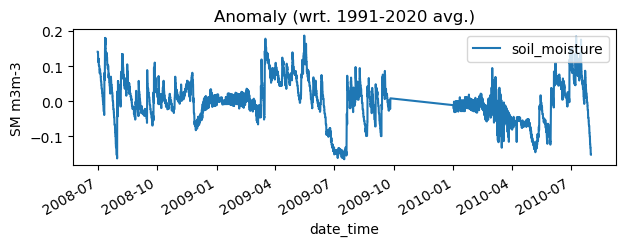

In [19]:
from pytesmo.validation_framework.adapters import AnomalyClimAdapter
ds_mask = AnomalyClimAdapter(ismn_reader, columns=['soil_moisture'], 
                             timespan=(datetime(1991,1,1), datetime(2020,12,31)))
anom = ds_mask.read(ids[0])
pprint(anom)
anom.plot(title='Anomaly (wrt. 1991-2020 avg.)', ylabel='SM m3m-3', figsize=(7,2))

## ColumnCombineAdapter

This adapter is used to combine multiple columns of a dataset after reading the time series. It takes any function that can be applied accross multiple columns and will add a new column of the chosen name to the data frame.
E.g. in the following example we combine the `proc_flag` and `snow_prob` and `frozen_prob` column into a new column `good` that is 'True' when all the chosen columns are 0 and otherwise 'False'. Then we apply a `SelfMaskingAdapter` that uses the newly added column to filter the dataset. This is just for demonstration, we could also just use the `AdvancedMaskingAdapter` for this example. A more common use case for the `ColumnCombineAdapter` would be to compute the average when multiple soil moisture fields are available in a dataset.

This example also shows that you can stack multiple adapters together. If they depend on each other, it is important to notice that the innermost adapter will be called first!

In [20]:
from pytesmo.validation_framework.adapters import ColumnCombineAdapter, SelfMaskingAdapter

def select_good(x):
    return (x['proc_flag'] == 0) and (x['snow_prob'] == 0) and (x['frozen_prob'] == 0)

ds_mask = SelfMaskingAdapter(ColumnCombineAdapter(ascat_reader, func=select_good, new_name='good'), 
                             '==', True, 'good')
pprint(ds_mask.read(1814367)[['sm', 'proc_flag', 'snow_prob', 'frozen_prob', 'good']])

                              sm  proc_flag  snow_prob  frozen_prob  good
2007-06-03 03:33:38.999992  84.0          0          0            0  True
2007-06-03 14:51:50.999997  82.0          0          0            0  True
2007-06-06 02:31:33.000005  76.0          0          0            0  True
2007-06-06 13:49:46.999999  75.0          0          0            0  True
2007-06-08 03:30:13.000023  83.0          0          0            0  True
...                          ...        ...        ...          ...   ...
2014-06-25 13:51:37.000006  83.0          0          0            0  True
2014-06-27 03:32:04.999979  79.0          0          0            0  True
2014-06-27 14:50:18.000019  81.0          0          0            0  True
2014-06-30 02:30:05.000000  77.0          0          0            0  True
2014-06-30 13:48:17.999999  83.0          0          0            0  True

[713 rows x 5 columns]
